In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = "D:/American_Sign_Language/asl_alphabet_train/asl_alphabet_train"
LABELS = sorted(os.listdir(DATASET_PATH))
OUTPUT_MODEL = "sign_model_3dtilt.h5"
AUGMENT_ANGLES_Z = [-15, 15]
AUGMENT_ANGLES_3D = [(-15, 0), (15, 0), (0, -15), (0, 15)]  # (x_tilt, y_tilt)

In [4]:
def rotate_landmarks_z(landmarks, angle_degrees):
    """In-plane (Z-axis) rotation"""
    angle = np.radians(angle_degrees)
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    landmarks = np.array(landmarks).reshape(-1, 3)
    x, y = landmarks[:, 0], landmarks[:, 1]
    cx, cy = np.mean(x), np.mean(y)
    x -= cx
    y -= cy
    x_rot = x * cos_a - y * sin_a
    y_rot = x * sin_a + y * cos_a
    x_rot += cx
    y_rot += cy
    landmarks[:, 0] = x_rot
    landmarks[:, 1] = y_rot
    return landmarks.flatten()

def rotate_landmarks_3d(landmarks, angle_x=0, angle_y=0):
    """Out-of-plane (X, Y axis) rotation"""
    angle_x = np.radians(angle_x)
    angle_y = np.radians(angle_y)

    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])
    Ry = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])
    R = Ry @ Rx

    landmarks = np.array(landmarks).reshape(-1, 3)
    landmarks = landmarks - np.mean(landmarks, axis=0)
    rotated = landmarks @ R.T
    rotated = rotated + np.mean(landmarks, axis=0)
    return rotated.flatten()


In [5]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
data = []

print("📥 Extracting and augmenting landmarks...")
for label in LABELS:
    label_dir = os.path.join(DATASET_PATH, label)
    success = 0
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        image = cv2.imread(img_path)
        if image is None:
            continue
        result = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if result.multi_hand_landmarks:
            hand = result.multi_hand_landmarks[0]
            landmarks = []
            for lm in hand.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

            # Add original
            data.append(landmarks + [label])

            # Add Z-rotated
            for angle in AUGMENT_ANGLES_Z:
                rotated_z = rotate_landmarks_z(landmarks, angle)
                data.append(list(rotated_z) + [label])

            # Add 3D rotated
            for angle_x, angle_y in AUGMENT_ANGLES_3D:
                rotated_3d = rotate_landmarks_3d(landmarks, angle_x, angle_y)
                data.append(list(rotated_3d) + [label])
            success += 1
    print(f"{label}: {success} images processed")


📥 Extracting and augmenting landmarks...
A: 2193 images processed
B: 2210 images processed
C: 1991 images processed
D: 2463 images processed
E: 2310 images processed
F: 2882 images processed
G: 2442 images processed
H: 2394 images processed
I: 2386 images processed
J: 2582 images processed
K: 2702 images processed
L: 2527 images processed
M: 1591 images processed
N: 1298 images processed
O: 2271 images processed
P: 2043 images processed
Q: 2107 images processed
R: 2547 images processed
S: 2555 images processed
T: 2349 images processed
U: 2520 images processed
V: 2551 images processed
W: 2459 images processed
X: 2159 images processed
Y: 2585 images processed
Z: 2352 images processed
del: 1708 images processed
nothing: 3 images processed
space: 1651 images processed


In [6]:
df = pd.DataFrame(data)
df.to_csv("landmarks_3daug.csv", index=False)
print("✅ Augmented dataset saved as 'landmarks_3daug.csv'")

✅ Augmented dataset saved as 'landmarks_3daug.csv'


In [7]:
print("⚙️ Preprocessing...")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

y_train_oh = to_categorical(y_train, num_classes)
y_test_oh = to_categorical(y_test, num_classes)


⚙️ Preprocessing...


In [8]:
print("🧠 Training model...")

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train_oh,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    verbose=1
)


🧠 Training model...


c:\Users\HP\Desktop\American_Sign_Language_Detection\venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7947 - loss: 0.6861 - val_accuracy: 0.9708 - val_loss: 0.0938
Epoch 2/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9604 - loss: 0.1313 - val_accuracy: 0.9818 - val_loss: 0.0633
Epoch 3/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9676 - loss: 0.1063 - val_accuracy: 0.9797 - val_loss: 0.0624
Epoch 4/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9712 - loss: 0.0938 - val_accuracy: 0.9832 - val_loss: 0.0547
Epoch 5/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9727 - loss: 0.0884 - val_accuracy: 0.9832 - val_loss: 0.0513
Epoch 6/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9747 - loss: 0.0822 - val_accuracy: 0.9863 - val_loss: 0.0439
Epoch 7/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9757 - loss: 0.0790 - val_accuracy: 0.9843 - val_loss: 0.0481
Epoch 8/30
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9773 - loss: 0

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.9916


In [10]:
model.save(OUTPUT_MODEL)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("💾 Model + scaler + encoder saved.")

💾 Model + scaler + encoder saved.


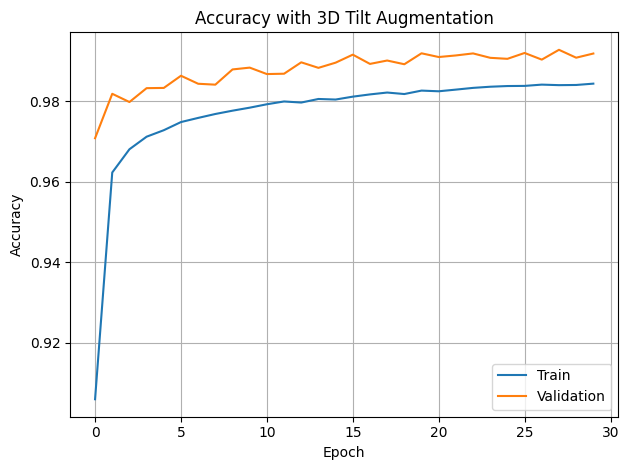

In [11]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy with 3D Tilt Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()